<h1><center>DSA 4212: Year 2022</center></h1>
<h3><center> Assignment 1 (Deadline: Sunday 27th March at 23:59) </center></h3>
<h4><center> Group Number: ???? </center></h4>
<h4><center> Filename: assignment_1_XX.ipynb where XX is your group number</center></h4>
<h4><center> Group Member 1: Student Name, Student ID </center></h4>
<h4><center> Group Member 2: Student Name, Student ID </center></h4>
<h4><center> Group Member 3: Student Name, Student ID </center></h4>
<h4><center> Group Member 4: Student Name, Student ID </center></h4>

**Remark:** as described below, each group has to submit two documents on lumiNUS: 
1. a jupyter notebook with your code  
2. a pdf report explaining your approaches and conclusions.
3. you can have a look at `https://www.overleaf.com/read/xmvqgpsdqwyx` if you would like to use Overleaf and Latex to rapidly produce a neat report. You can use your NUS email to create an Overleaf account.

**File naming convention:**
1. the Jupyter notebook needs to be named `assignment_1_XX.ipynb`. For example, group number 3 needs to name its jupyter notebook as `assignment_1_03.ipynb`.
1. the pdf report needs to be named `assignment_1_XX.pdf`. For example, group number 3 needs to name its pdf report as `assignment_1_03.pdf`.



**To load data on Google Colab**:
1. Upload the data onto your Google Drive
2. Run the first cell to log in your Google account and mount on your Google Drive
3. Change *path_csv* and *path* accordingly

In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

In [ ]:
# Google Colab import data: Much Faster to unzip files

!unzip "/content/gdrive/My Drive/DSA4212/datasets/img_celeba_small.zip" -d "/content"

In [ ]:
%matplotlib inline
from jax.config import config
config.update("jax_enable_x64", True) # for higher accuracy

import jax
import jax.numpy as jnp
import numpy as np

import pylab as plt
import imageio
import os
import numpy as onp
# to install scikit-image: !pip install scikit-image
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import time

In [ ]:
#load attributes csv file
path_csv  = "D:\\Academics\\DSA\\4212\\datasets" # Local Path (Change Here)
# path_csv  = '/content/gdrive/My Drive/DSA4212/datasets' # Google Drive
attribute = pd.read_csv(os.path.join(path_csv, "celeba.csv"))


In [ ]:
#let us list all the files in the image directory
path = "D:\\Academics\\DSA\\4212\\datasets\\img_celeba_small" # Local Path (Change Here)
# path = "/content/img_celeba_small" # Google Drive
all_img = [f for f in os.listdir(path) 
                 if os.path.isfile(os.path.join(path, f)) 
                 and f.endswith(".jpg")]

# sort the images by alphabetical order 
# !!!! VERY IMPORTANT in order to be consistent with the labels contained in celeba.csv !!!!
all_img.sort()
nb_img = len(all_img)
print("Number of images:", nb_img)

#let us keep only the relevant attributes
attribute = attribute[:20000]

Number of images: 20000


## Common Utility Functions

In [ ]:
# #let us load the first 500 images
# n_img = 500
# img_array = onp.zeros((n_img, 100,100))
# for k in range(n_img):
#     im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
#     im = resize(im, (100,100) )
#     im = onp.mean(im, axis=2) # average the last channel
#     img_array[k,:,:] = im
    
def image_loader(indices, res, grey=False, verbose = 0):
    """
    Load Images

    args:
    indices: indices of the image to be loaded
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((indices.size, res[0], res[1]))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
            if verbose == 1 & i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((indices.size, res[0], res[1], 3))
        i = 0
        for k in indices:
            im = imageio.imread(os.path.join(path, all_img[k])).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            if verbose == 1 & i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
        
    return img_array

def image_loader_fname(fnames, res, grey=False):
    """
    Load Images by File Names

    args:
    fnames: file names of the image to be loaded (a list)
    res: resolution of the image, an iterable of size 2
    grey: boolean to decide whether loaded images are grey scaled. Default is False (color images)
    verbose: Print time elapsed for every 1000 loaded images if verbose == 1, default 0
    """
    start = time.time()
    if grey == True:
        img_array = onp.zeros((len(fnames), res[0], res[1]))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            im = onp.mean(im, axis=2) # average the last channel
            img_array[i,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, res[0]*res[1])
    else:
        img_array = onp.zeros((len(fnames), res[0], res[1], 3))
        i = 0
        for name in fnames:
            im = imageio.imread(os.path.join(path, name)).astype(float)
            im = resize(im, (res[0],res[1]) )
            img_array[i,:,:,:] = im
            i += 1
            if i % 1000 == 0:
                end = time.time()
                duration = end - start
                print(f"Number of images imported: {i}, Time elapsed: {duration:.2f}")
        img_array = img_array.reshape(-1, 3*res[0]*res[1])
            
    return img_array

## Utility Functions for Basic Logistic Regression

In [ ]:
@jax.jit
def pred_proba(beta, x):
    """ predict the probability that label is +1 given x and beta """
    return 1. / (1. + jnp.exp(-jnp.dot(beta, x)))

pred_proba_batch = jax.vmap(pred_proba, in_axes=(None, 0)) # Vectorize Predict Function

In [ ]:
@jax.jit
def loss_single(beta, x, y):
    """ logistic regression loss on a single image """
    return jnp.log(1. + jnp.exp(-y*jnp.dot(x,beta)))
loss_batch = jax.vmap(loss_single, in_axes=(None, 0, 0)) # Vectorize Loss Function

In [ ]:
@jax.jit
def loss_LR(beta, X, Y):
    """
    Minibatch Logistic regression loss
    
    args:
    ====
     beta: LR parameter
     X: array[:,:] of images
     Y: array[:] of labels
    """
    # compute all the individual losses
    losses = loss_batch(beta, X, Y)
    return jnp.mean(losses)

# compute derivates
loss_LR_grad = jax.jit(jax.grad(loss_LR, argnums=0))
loss_LR_values_and_grad = jax.jit(jax.value_and_grad(loss_LR, argnums=0))

In [ ]:
@jax.jit
def get_label(p, threshold=0.5):
    pred_bool = p > threshold
    pred_label = 2*pred_bool - 1
    return pred_label

def get_accuracy(p, Y):
    """ Compare the predicted probability (p) with the ground truth labels (Y) to get the accuracy """
    return jnp.mean(Y==get_label(p))

from sklearn.metrics import roc_auc_score

def get_auc(p, Y):
    return roc_auc_score(p, Y)

In [ ]:
def test_acc_auc(beta, Y_true, test_img_arr):
    """
    Get the accuracy and AUC-ROC score for test data
     beta: Model Parameters
     Y_true: Ground truth labels
     test_img_arr: test images represented by an array
    """
    test_pred = pred_proba_batch(beta, test_img_arr)
    test_acc = get_accuracy(test_pred, Y_true)
    test_auc = get_auc(Y_true, test_pred)
    
    print(f'Test Accuracy is {test_acc:.2f}')
    print(f'Test AUC is {test_auc:.2f}')
    
    return test_acc, test_auc

## Utility Functions for Regularized Logistic Regression (Ridge, Lasso, ...)

In [ ]:
### To be completed...

## Utility Functions for Training Model and Backcalling

In [ ]:
def train_SGD(train_img, train_label, beta_init, lr, val_grad_fn, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels using Stochastic Gradient Descent (SGD)
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
    
    return loss_history, loss_history_end_epoch, test_acc_history, beta

In [ ]:
def train_SGD_step_decay(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with step decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    test_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        test_proba = pred_proba_batch(beta, test_img_arr)
        test_acc = get_accuracy(test_proba, test_label)
        test_acc_history.append(test_acc)
        
        if (epoch + 1) % n_steps == 0:
            learning_rate = learning_rate * lr_decay
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
    return loss_history, loss_history_end_epoch, test_acc_history, beta

In [ ]:
def train_SGD_heuristic(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, valid_size=0.2, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with heuristic learning rate decay using SGD with heuristic learning rate decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     valid_size: Proportion of training images to be used as validation data
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     valid_acc_history: Valid accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    loss_history_end_epoch = []
    loss_history = []
    valid_acc_history = []
    beta = np.copy(beta_init)
    learning_rate = lr
    
    valid_img_arr = train_img[int(-valid_size*N):]
    valid_label = train_label[int(-valid_size*N):]

    for epoch in range(n_epoch):
        # go through all the minibatches, sequetially
        start = time.time()
        n_minibatch = N // minibatch_size + 1
        # randomize the batches
        np.random.shuffle(img_indices)

        all_loss_within_epoch = []
        for k in range(n_minibatch):
            # create the minibatch of examples
            batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
            batch_indices = img_indices[batch_indices]
            X_minibatch = train_img[batch_indices]
            Y_minibatch = train_label[batch_indices]

            # compute the stochastic gradient
            val, grad = val_grad_fn(beta, X_minibatch, Y_minibatch)

            # do one step of SGD
            beta = beta - learning_rate*grad

            # book-keeping
            loss_history.append(val)
            all_loss_within_epoch.append(val)
            
        loss_history_end_epoch.append(np.mean(all_loss_within_epoch))
        end = time.time()
        duration = end - start
        
        valid_acc_new = get_accuracy(pred_proba_batch(beta, valid_img_arr), valid_label)
        valid_acc_history.append(valid_acc_new)
        
        if epoch == 0:
            valid_acc = valid_acc_new
        elif valid_acc_new < valid_acc:
            learning_rate = learning_rate * lr_decay
        valid_acc = valid_acc_new
        
        if verbose == 1:
            print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Validation Accuracy: {valid_acc:.3f}")
    return loss_history, loss_history_end_epoch, valid_acc_history, beta

In [ ]:
def train_SGD_scheduled_decay(train_img, train_label, beta_init, lr, val_grad_fn, lr_decay=0.5, n_steps=5, verbose = 0, n_epoch=10, mb_size=100):
    """
     Find optimized beta given train images and train labels with fix epoch learning rate decay using SGD with scheduled decay
     
    Inputs:
     train_img: Training images (in the format of [n,:] array, where n is the number of images)
     train_label: Training labels (in the format of [n, 1] array, where n is the number of labels)
     beta: Starting point of beta (weights)
     lr: Learning rate
     val_grad_fn: Function to return the loss value and gradient given X and Y
     lr_decay: Learning rate decay rate, default 0.5
     n_steps: Number of epochs to decay the learning rate
     verbose: Print time elapsed, training loss and test accuracy for each epoch if verbose = 1, default 0
     n_epoch: Number of epoch to run the algo, default 10
     mb_size: Minibatch size, default 100
     
    Outputs:
     loss_history: Loss for training history at end of each minibatch
     loss_history_end_epoch: Loss at the end of each epoch
     test_acc_history: Test accuracy at the end of each epoch
     beta: The final updated values of beta
    """
    minibatch_size = mb_size #size of the minibatchs
    N = len(train_img)  #15000, total number of images
    img_indices = np.arange(N)

    test_acc_history = [[] for x in range(5)]
    loss_history = [[] for x in range(5)]
    loss_history_end_epoch = [[] for x in range(5)]
    decay_constant = [0.1, 0.3, 0.5, 0.7, 0.9] # lambdas 
    learning_rate = lr

    for i in range(len(decay_constant)):
        print("Lambda:",decay_constant[i])
        beta = np.copy(beta_init)
        learning_rate = lr

        for epoch in range(n_epoch):
            # go through all the minibatches, sequetially
            start = time.time()
            n_minibatch = N // minibatch_size + 1
            # randomize the batches
            np.random.shuffle(img_indices)
    
            all_loss_within_epoch = []
            for k in range(n_minibatch):
                # create the minibatch of examples
                batch_indices = np.arange(k*minibatch_size, (k+1)*minibatch_size) % N
                batch_indices = img_indices[batch_indices]
                X_minibatch = train_img_arr[batch_indices]
                Y_minibatch = train_label[batch_indices]

                # compute the stochastic gradient
                val, grad = loss_LR_values_and_grad(beta, X_minibatch, Y_minibatch)

                # do one step of SGD
                beta = beta - learning_rate*grad

                # book-keeping
                loss_history[i].append(val)
                all_loss_within_epoch.append(val)

            loss_history_end_epoch[i].append(np.mean(all_loss_within_epoch))
            end = time.time()
            duration = end - start

            test_proba = pred_proba_batch(beta, test_img_arr)
            test_acc = get_accuracy(test_proba, test_label)
            test_acc_history.append(test_acc)

            learning_rate = learning_rate /(1 + decay_constant[i]*epoch) # Schedule decay

            test_acc, _ = test_acc_auc(beta, test_label, test_img_arr)

            if verbose == 1:
                print(f"Epoch {epoch}: {duration:.2f} seconds, Loss: {loss_history_end_epoch[-1]:.2f}, Test Accuracy: {test_acc:.3f}")
                
    return loss_history, loss_history_end_epoch, test_acc_history, beta
       

## Utility Functions for Plotting Graph

In [ ]:
def plot_loss(loss_history):
    plt.plot(loss_history, "-^")
    plt.yscale("log")
    plt.xlabel("Epochs")
    plt.grid(True)

## Import Data
### Notice: Images are only loaded as file names at this stage, to read as numerical arrays, use image_loader/image_loader_fname

In [ ]:
# Proportion of Males in first 15000? first 200?
train_img = all_img[:15000]
train_label = attribute['Male'][:15000]
train_label = np.array(train_label).reshape(-1)

test_img = all_img[15000:]
test_label = attribute['Male'][15000:]
test_label = np.array(test_label).reshape(-1)

train_small_img = all_img[:200]
train_small_label = attribute['Male'][:200]
train_small_label = np.array(train_small_label).reshape(-1)

### Delete the arrays to clear up memeory and prevent RAM OOM

In [ ]:
import gc
def clear_image_cache(var_list):
    for var in var_list:
        if var in globals().keys():
            del globals()[var]
    gc.collect()
# del test_img_arr
# del train_img_arr

### Convert images into numerical arrays

In [ ]:
img_list = ['test_img_arr', 'train_img_arr']
clear_image_cache(img_list)

pixels = 178
res = [pixels, pixels]
grey = False

train_img_arr = image_loader_fname(train_img, res, grey)
test_img_arr = image_loader_fname(test_img, res, grey)

Number of images imported: 1000, Time elapsed: 13.27
Number of images imported: 2000, Time elapsed: 26.85
Number of images imported: 3000, Time elapsed: 41.71
Number of images imported: 4000, Time elapsed: 55.98
Number of images imported: 5000, Time elapsed: 69.81
Number of images imported: 6000, Time elapsed: 83.43
Number of images imported: 7000, Time elapsed: 96.79
Number of images imported: 8000, Time elapsed: 110.42
Number of images imported: 9000, Time elapsed: 126.09
Number of images imported: 10000, Time elapsed: 142.15
Number of images imported: 11000, Time elapsed: 155.42
Number of images imported: 12000, Time elapsed: 168.94
Number of images imported: 13000, Time elapsed: 177.68
Number of images imported: 14000, Time elapsed: 186.02
Number of images imported: 15000, Time elapsed: 194.90
Number of images imported: 1000, Time elapsed: 8.83
Number of images imported: 2000, Time elapsed: 17.52
Number of images imported: 3000, Time elapsed: 26.41
Number of images imported: 4000, 

In [ ]:
train_img_arr.shape

(15000, 95052)

In [ ]:
test_img_arr.shape

(5000, 95052)

## Basic SGD

In [ ]:
# initialize beta at random
np.random.seed(42)
beta_standard_dev = 1. / np.sqrt(3) / pixels
beta_init = np.random.normal(0,beta_standard_dev,3*pixels*pixels)

In [ ]:
loss_SGD, loss_epoch_SGD, test_acc_SGD, beta_SGD = train_SGD(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, mb_size = 100, verbose = 1)

Epoch 0: 21.60 seconds, Loss: 12.12, Test Accuracy: 0.664
Epoch 1: 52.55 seconds, Loss: 9.22, Test Accuracy: 0.650
Epoch 2: 51.95 seconds, Loss: 8.01, Test Accuracy: 0.705
Epoch 3: 46.28 seconds, Loss: 7.21, Test Accuracy: 0.710
Epoch 4: 36.64 seconds, Loss: 6.44, Test Accuracy: 0.730
Epoch 5: 54.54 seconds, Loss: 5.98, Test Accuracy: 0.742
Epoch 6: 49.16 seconds, Loss: 5.58, Test Accuracy: 0.748
Epoch 7: 53.30 seconds, Loss: 5.27, Test Accuracy: 0.756
Epoch 8: 50.48 seconds, Loss: 5.01, Test Accuracy: 0.759
Epoch 9: 46.95 seconds, Loss: 4.78, Test Accuracy: 0.769


KeyboardInterrupt: 

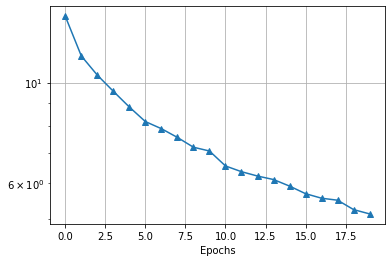

In [ ]:
plot_loss(loss_epoch_SGD)

In [ ]:
acc_test, auc_test = test_acc_auc(beta_SGD, test_label, test_img_arr)

Test Accuracy is 0.75
Test AUC is 0.81


## Annealing

### Step Decay

In [ ]:
loss_step, loss_epoch_step, test_acc_step, beta_step = train_SGD_step_decay(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, verbose = 1)

Epoch 0: 62.71 seconds, Loss: 12.20, Test Accuracy: 0.667
Epoch 1: 45.46 seconds, Loss: 9.27, Test Accuracy: 0.668
Epoch 2: 42.44 seconds, Loss: 7.92, Test Accuracy: 0.698
Epoch 3: 46.63 seconds, Loss: 7.03, Test Accuracy: 0.718
Epoch 4: 44.87 seconds, Loss: 6.46, Test Accuracy: 0.729
Epoch 5: 58.05 seconds, Loss: 5.92, Test Accuracy: 0.733
Epoch 6: 48.99 seconds, Loss: 5.71, Test Accuracy: 0.737
Epoch 7: 35.29 seconds, Loss: 5.53, Test Accuracy: 0.742
Epoch 8: 49.77 seconds, Loss: 5.38, Test Accuracy: 0.754
Epoch 9: 50.96 seconds, Loss: 5.21, Test Accuracy: 0.752


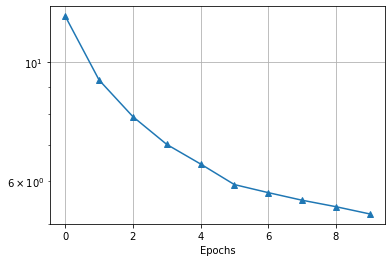

In [ ]:
plot_loss(loss_epoch_step)

In [ ]:
acc_test, auc_test = test_acc_auc(beta_step, test_label, test_img_arr)

Test Accuracy is 0.75
Test AUC is 0.82


### Heuristic

In [ ]:
loss_heuristic, loss_epoch_heuristic, valid_acc_heuristic, beta_heuristic = train_SGD_heuristic(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, verbose = 1)

Epoch 0: 62.06 seconds, Loss: 12.06, Validation Accuracy: 0.641
Epoch 1: 28.57 seconds, Loss: 9.16, Validation Accuracy: 0.664
Epoch 2: 17.47 seconds, Loss: 7.91, Validation Accuracy: 0.689
Epoch 3: 13.47 seconds, Loss: 7.10, Validation Accuracy: 0.691
Epoch 4: 17.64 seconds, Loss: 6.56, Validation Accuracy: 0.715
Epoch 5: 11.39 seconds, Loss: 5.98, Validation Accuracy: 0.729
Epoch 6: 8.05 seconds, Loss: 5.69, Validation Accuracy: 0.736
Epoch 7: 7.94 seconds, Loss: 5.38, Validation Accuracy: 0.746
Epoch 8: 8.36 seconds, Loss: 5.06, Validation Accuracy: 0.746
Epoch 9: 8.12 seconds, Loss: 4.81, Validation Accuracy: 0.742


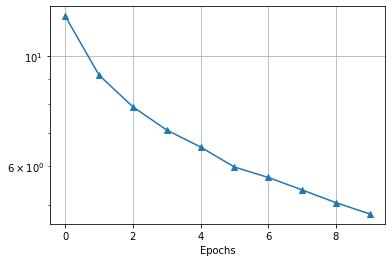

In [ ]:
plot_loss(loss_epoch_heuristic)

In [ ]:
acc_test, auc_test = test_acc_auc(beta_heuristic, test_label, test_img_arr)

Test Accuracy is 0.75
Test AUC is 0.83


### 1/t decay

In [ ]:
### To be completed...
loss_step, loss_epoch_step, test_acc_step, beta_step = train_SGD_scheduled_decay(
    train_img_arr, train_label, beta_init, 1e-7, loss_LR_values_and_grad, n_epoch = 10, verbose = 1)

## Momentum a.k.a Heavy Ball Method

In [ ]:
### To be completed...